# RFI Mitigation

[Your](https://thepetabyteproject.github.io/your/your/#your) is equipped with a few powerful  
(RFI) mitigation techniques. To get started we import some useful stuff and define a handy plotter.

In [1]:
import your
import pylab as plt
import numpy as np
from matplotlib import gridspec
from your.candidate import Candidate

In [2]:
def plot_data(data, fil, dm, mask=None):
    channels = np.arange(data.shape[1])
    c = Candidate(fp=fil, dm=dm, tcand=2.0288800, width=64, label=-1, snr=16.8128, min_samp=256, device=0)
    c.data = data
    c.dedisperse(target='GPU')
    data = c.dedispersed
    bandpass = data.mean(0)
    ts = data.mean(1)
    
    if mask is not None:
        data[:, mask] = 0

    fig = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3])

    ax0 = plt.subplot(gs[1, 0])
    ax0.imshow(data.T, aspect="auto", interpolation=None)
    ax0.set_xlabel("Time Samples")
    ax0.set_ylabel("Frequency Channels")

    ax1 = plt.subplot(gs[1, 1], sharey=ax0)
    plt.setp(ax1.get_yticklabels(), visible=False)
    ax1.plot(bandpass, channels, "k")
    ax1.set_xlabel("Flux (Arb. Units)")
    
    ax2 = plt.subplot(gs[0, 0], sharex=ax0)
    plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.plot(ts, "k")
    ax2.set_ylabel("Flux (Arb. Units)")

    if mask is not None:
        for channel, val in zip(channels[mask], bandpass[mask]):
            ax0.axhline(channel, color="r", xmin=0, xmax=0.03, lw=0.1)
            ax1.scatter(val, channel, color="r", marker="o")

    plt.tight_layout()
    return plt.show()

## Reading data

Let's read a filterbank file with a PSR B0329+54 single pulse.

In [3]:
import tempfile
from urllib.request import urlretrieve

In [4]:
temp_dir = tempfile.TemporaryDirectory()
download_path = str(temp_dir.name) + "/B0329+54.fil"
url = "https://zenodo.org/record/3905426/files/B0329+54.fil"
urlretrieve(
    url, download_path,
)
fil = download_path

In [5]:
dm = 26.7641

In [6]:
your_object = your.Your(fil)
your_data = your_object.get_data(1200, 2000)

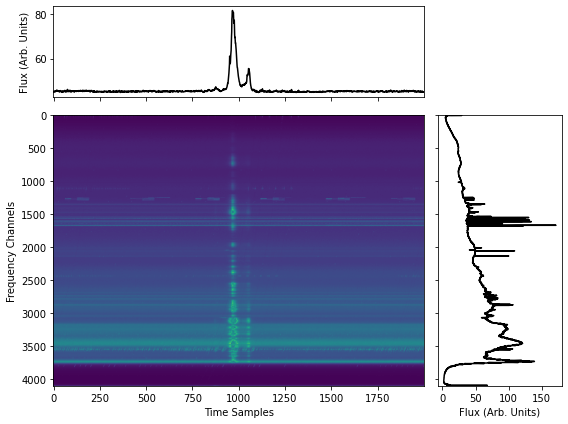

In [7]:
plot_data(your_data, fil=fil, dm=dm)

## Savitzky–Golay filter

We first use the Savitzky–Golay filter ([`savgol_filter`](https://thepetabyteproject.github.io/your/utils/rfi/#savgol_filter)) as detailed in [Agarwal el al. 2020](https://arxiv.org/abs/2003.14272). It tries to fit a smooth function to the bandpass and flags anything outside `sigma=6` values.

In [8]:
savgol_mask = your.utils.rfi.savgol_filter(your_data.mean(0), your_object.foff)

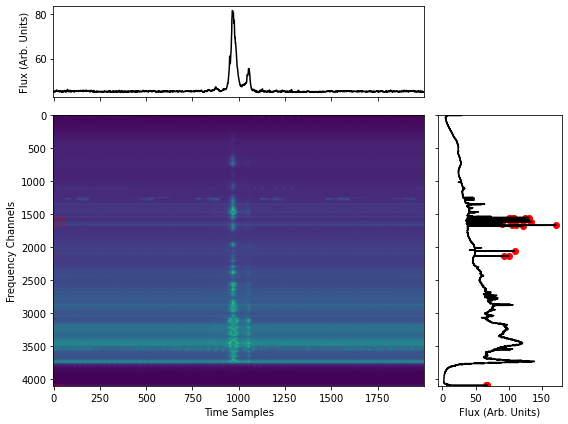

In [9]:
plot_data(your_data, fil=fil, dm=dm, mask=savgol_mask)

We can also change the width of the window and sigma to do more aggressive filtering by changing `frequency_window` to 30 MHz and `sigma` to 3.

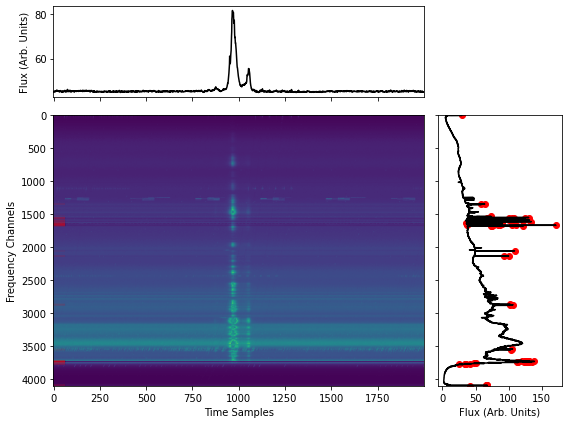

In [10]:
savgol_mask = your.utils.rfi.savgol_filter(
    your_data.mean(0), your_object.foff, frequency_window=30, sigma=3
)
plot_data(your_data, fil=fil, dm=dm, mask=savgol_mask)

## Spectral Kurtosis filter

We also have Spectral Kurtosis filter ([`sk_filter`](https://thepetabyteproject.github.io/your/utils/rfi/#spectral_kurtosis)) as detailed in [Nita et al. (2016)](https://doi.org/10.1109/RFINT.2016.7833535). Our implementation differs sligtly from [Nita et al. (2016)](https://doi.org/10.1109/RFINT.2016.7833535) as we flag anything outside 5 `sigma` of the Spectral Kurtosis.

In [11]:
spectral_kurtosis_mask = your.utils.rfi.sk_filter(
    your_data,
    your_object.your_header.foff,
    your_object.your_header.nchans,
    your_object.your_header.tsamp,
    sigma=5,
)

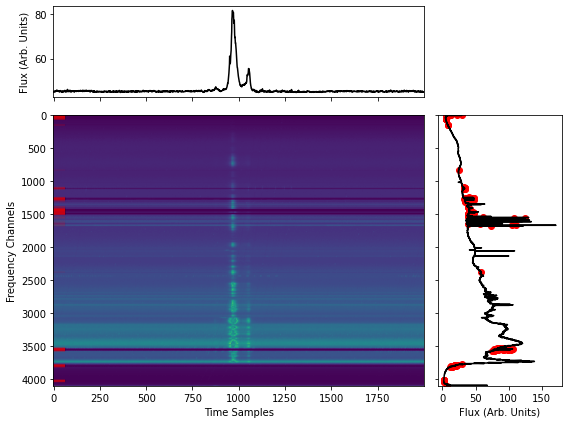

In [12]:
plot_data(your_data, fil=fil, dm=dm, mask=spectral_kurtosis_mask)

## Composite filter

We can use both Spectral Kurtosis and the Savitzky–Golay filter together with the [`sk_sg_filter`](https://thepetabyteproject.github.io/your/utils/rfi/#sk_sg_filter) function.

In [13]:
composite_mask = your.utils.rfi.sk_sg_filter(
    your_data, your_object, your_object.your_header.nchans
)

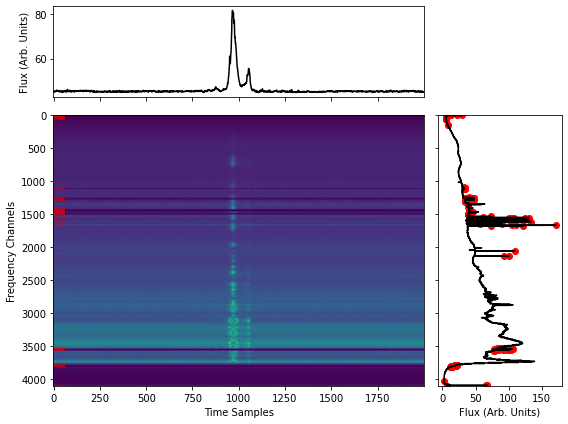

In [14]:
plot_data(your_data, fil=fil, dm=dm, mask=composite_mask)